# <center>  PRÁCTICA: TRICICLOS EN UN GRAFO 
<center> Antonio Fco. Álvarez Gómez

In [1]:
#pip install --user decorator==4.3.0

### 1.  Triciclos ( 3-ciclos )
Los triciclos, o más formalmente 3-ciclos, son un elemento básico en el análisis de grafos y subgrafos. Los 3-ciclos muestran una relación estrecha entre 3 entidades (vértices): cada uno de los vértices está relacionado (tiene aristas) con los otros dos.

Escribe un programa paralelo que calcule los 3-ciclos de un grafo denido como lista de aristas.

In [1]:
from pyspark import SparkContext
sc = SparkContext()

Se crea la función auxiliar get_edges, que ordena un par de vértices de forma lexicográfica. Si fueran iguales devolvería None.

In [2]:
def get_edges(line):
    edge = line.strip().split(',')
    n1 = edge[0]
    n2 = edge[1]
    if n1 < n2:
         return (n1,n2)
    elif n1 > n2:
         return (n2,n1)

In [3]:
import networkx as nx
from networkx.drawing.nx_pylab import draw

La función read_graph abre un fichero y devuelve el grafo de este.

In [4]:
def read_graph(filename):
    graph = nx.Graph()
    with open(filename) as f:
        for line in f:
            graph.add_edge(*line.strip().split(','))
    return graph

**Ejemplo:** Consideremos el siguiente grafo: 

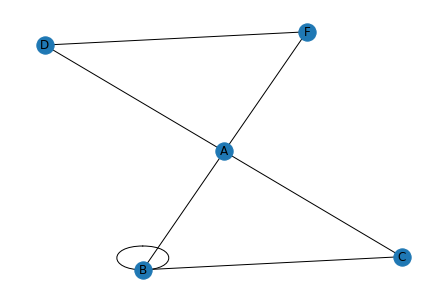

In [5]:
g = read_graph("triciclos.txt")
draw(g, with_labels=True)

Un posible conjunto de aristas que lo den es:

<center> {(B, B), (B, A), (C, A), (A, B), (A, D), (B, C), (F, A), (F, D)} 
    
y el conjunto de los 3-ciclos del grafo son:
    
<center>  {(A, B, C), (D, A, F )}

In [6]:
linea = "b,a"
get_edges(linea)

('a', 'b')

La función get_rdd_distict_edges aplica la función get_edges a un grafo entero y así se detectan las que estén repetidas o las que sean un nodo en sí mismo y se eliminan.

In [7]:
def get_rdd_distict_edges(sc, filename):
    return sc.textFile(filename).\
        map(get_edges).\
        filter(lambda x: x is not None).\
        distinct()

La función aristas recibe una lista de índices con sus adyacentes y para cada nodo va generando las aristas que ve que existen porque entre nodos adyacentes hay una arista y luego recorre los adyacentes de ese mismo nodo y las posibles aristas que formarían entre sí las etiqueta como pending. Si existiera, se tendría el triángulo buscado.

In [8]:
def aristas_(vertices_adyacentes):
    vertices,adyacentes = vertices_adyacentes
    adyacentes = list(adyacentes)
    aristas = []
    for adyacente in adyacentes:
        aristas.append(((vertices,adyacente),'exists'))
        for otros_adyacentes in adyacentes:
            if adyacente < otros_adyacentes:
                aristas.append(((adyacente,otros_adyacentes),('pending', vertices)))
    return aristas

In [9]:
pista = ('A',['B', 'D', 'F', 'C'])
aristas_(pista)

[(('A', 'B'), 'exists'),
 (('B', 'D'), ('pending', 'A')),
 (('B', 'F'), ('pending', 'A')),
 (('B', 'C'), ('pending', 'A')),
 (('A', 'D'), 'exists'),
 (('D', 'F'), ('pending', 'A')),
 (('A', 'F'), 'exists'),
 (('A', 'C'), 'exists'),
 (('C', 'D'), ('pending', 'A')),
 (('C', 'F'), ('pending', 'A'))]

Se buscan ahora tres nodos adyacentes y formen aristas dos a dos.

In [10]:
def triangulos_(arista_etiquetas):
    arista, etiquetas = arista_etiquetas
    etiquetas = list(etiquetas)
    triangulos = []
    if 'exists' in etiquetas:
        for etiqueta in etiquetas:
            if etiqueta != 'exists' and etiqueta[0] == 'pending':
                triangulos.append(('triangulo', sorted([arista[0], arista[1], etiqueta[1]])))

    return triangulos


Se hace la función que de la lista de triciclos de un grafo determinado.

Se obtiene la lista de nodos con sus subyacentes, se etiqueta con aristas, se agrupan para no tener las aristas repetidas y se agrupan las etiquetas de cada una. Después, se ve cuáles forman un triángulo y se sacan los triángulos y el número de estos.

In [11]:
def triangulos1(sc,filename):
    nodes = get_rdd_distict_edges(sc, filename)
    adj = nodes.groupByKey()
    
    rdd_etiquetas_aristas = adj.\
        flatMap(aristas_).\
        groupByKey()
    
    rdd_triangulos = rdd_etiquetas_aristas.flatMap(triangulos_)
    
    for triangulo in rdd_triangulos.collect():
        print(triangulo)
        
        
    print("Número de triángulos: " + str(rdd_triangulos.count()))


In [12]:
triangulos1(sc,'g0.txt')

('triangulo', ['A', 'B', 'C'])
Número de triángulos: 1


In [13]:
triangulos1(sc,'g2.txt')

('triangulo', ['I', 'J', 'K'])
('triangulo', ['M', 'N', 'O'])
('triangulo', ['Q', 'R', 'S'])
('triangulo', ['C', 'D', 'E'])
('triangulo', ['O', 'P', 'Q'])
('triangulo', ['S', 'T', 'U'])
('triangulo', ['W', 'X', 'Y'])
('triangulo', ['A', 'Y', 'Z'])
('triangulo', ['E', 'F', 'G'])
('triangulo', ['G', 'H', 'I'])
('triangulo', ['K', 'L', 'M'])
('triangulo', ['A', 'B', 'C'])
('triangulo', ['U', 'V', 'W'])
Número de triángulos: 13


###  2. Datos en múltiples ficheros
Considera que los datos, es decir, la lista de las aristas, no se encuentran en un único chero sino en muchos.

Escribe un programa paralelo que calcule los 3-ciclos de un grafo que se encuentra denido en múltiples cheros de entrada.

Se unen los ficheros de una lista dada.

In [14]:
def unir_ficheros(filename_list):
        data = sc.emptyRDD()
        for filename in filename_list:
            data = data.union(sc.textFile(filename))
        return data.collect()    

Para ver si funciona, se separa el fichero g2.txt en otros dos (g2.1.txt' y g2.2.txt). 

In [15]:
lista_ficheros = ['g2.1.txt','g2.2.txt']
unir_ficheros(lista_ficheros)

['A,B',
 'B,C',
 'C,D',
 'D,E',
 'E,F',
 'F,G',
 'G,H',
 'H,I',
 'I,J',
 'J,K',
 'K,L',
 'L,M',
 'M,N',
 'N,O',
 'O,P',
 'P,Q',
 'Q,R',
 'R,S',
 'S,T',
 'T,U',
 'U,V',
 'V,W',
 'W,X',
 'X,Y',
 'Y,Z',
 'Z,A',
 'A,C',
 'C,E',
 'E,G',
 'G,I',
 'I,K',
 'K,M',
 'M,O',
 'O,Q',
 'Q,S',
 'S,U',
 'U,W',
 'W,Y',
 'Y,A']

Se crea una nueva versión de la función para sacar los triángulos.

In [16]:
def edges_unir(sc,filename_list):
    data = sc.emptyRDD()
    for filename in filename_list:
        data = data.union(sc.textFile(filename))
        #return data.collect()  
    return data.map(get_edges).filter(lambda x: x is not None).distinct()
        

In [17]:
def triangulos2(sc,filename_list):
    nodes = edges_unir(sc,filename_list)
    adj = nodes.groupByKey()
    
    rdd_etiquetas_aristas = adj.\
        flatMap(aristas_).\
        groupByKey()
    
    rdd_triangulos = rdd_etiquetas_aristas.flatMap(triangulos_)
    
    for triangulo in rdd_triangulos.collect():
        print(triangulo)
        
        
    print("Número de triángulos :" + str(rdd_triangulos.count()))
    

In [18]:
lista_ficheros = ['g2.1.txt','g2.2.txt']
triangulos2(sc,lista_ficheros)

('triangulo', ['A', 'Y', 'Z'])
('triangulo', ['S', 'T', 'U'])
('triangulo', ['C', 'D', 'E'])
('triangulo', ['W', 'X', 'Y'])
('triangulo', ['K', 'L', 'M'])
('triangulo', ['A', 'B', 'C'])
('triangulo', ['O', 'P', 'Q'])
('triangulo', ['I', 'J', 'K'])
('triangulo', ['M', 'N', 'O'])
('triangulo', ['Q', 'R', 'S'])
('triangulo', ['E', 'F', 'G'])
('triangulo', ['G', 'H', 'I'])
('triangulo', ['U', 'V', 'W'])
Número de triángulos :13


### 3. 3-ciclos locales
Supongamos que los datos del grafo se encuentran repartidos en múltiples cheros. Queremos calcular los 3-ciclos, pero sólamente aquellos que sean locales a cada uno de los cheros.

Escribe un programa paralelo que calcule independientemente los 3-ciclos de cada uno de los cheros de entrada.

Se crea una nueva versión para sacar los triángulos cuando los datos están en múltiples ficheros.

In [19]:
def triangulos_mult_ficheros(sc,filename_list):
    triangulos = []
    for filename in filename_list:
        print ('En ' + filename + ' tenemos estos 3-ciclos:')
        triangulos = triangulos1(sc,filename)

In [20]:
triangulos_mult_ficheros(sc, ['g0.txt', 'g1.txt'])

En g0.txt tenemos estos 3-ciclos:
('triangulo', ['A', 'B', 'C'])
Número de triángulos: 1
En g1.txt tenemos estos 3-ciclos:
('triangulo', ['A', 'B', 'D'])
('triangulo', ['A', 'C', 'D'])
('triangulo', ['B', 'C', 'D'])
('triangulo', ['A', 'B', 'C'])
Número de triángulos: 4


Finalmente, vemos que funciones funcionan:

In [21]:
triangulos2(sc, ['g0.txt','g1.txt'])

('triangulo', ['A', 'B', 'C'])
('triangulo', ['A', 'C', 'D'])
('triangulo', ['B', 'C', 'D'])
('triangulo', ['A', 'B', 'D'])
Número de triángulos :4


In [22]:
triangulos1(sc,'g1.txt')

('triangulo', ['A', 'B', 'D'])
('triangulo', ['A', 'C', 'D'])
('triangulo', ['B', 'C', 'D'])
('triangulo', ['A', 'B', 'C'])
Número de triángulos: 4


In [23]:
triangulos1(sc,'g0.txt')

('triangulo', ['A', 'B', 'C'])
Número de triángulos: 1
